##### <p><font size="5">
<b>AI-BASED  CHATBOT  FOR  PATIENT  HEALTHCARE </b></font></p>





HealthAQ is a medical chatbot that utilizes Natural Language Processing to provide responses to user medical questions. Built on pre-trained sentence similarity model from the HuggingFace Repository, the bot has been trained on a variety of medical queries sourced from websites such as WebMD and questionDoctor, with a total of roughly 30,000 back-and-forth conversations. 

It is advanced compared to traditional conversational chatbots as it generates its own replies by analyzing the context of the user's question.

Unlike traditional methods where the chatbot relies on pre-stored replies for a set of expected questions, HealthAQ generates its own responses based on the context of the user's query.

https://sbert.net/

Sentence-transformers is a library from hugging face that provides pre-trained sentence embedding models, which can be used to convert sentences into numerical vectors. These vectors can then be used to calculate the semantic similarity between sentences. 

*We used Sentence-transformers from Hugging-Face because*
1. **Pre-trained models:** Sentence-transformers provides a wide range of pre-trained models, such as BERT, RoBERTa, and ALBERT, which have been trained on large datasets and can be easily fine-tuned for specific tasks. This can save a lot of time and resources, as compared to training a model from scratch.

2. **High performance:** Sentence-transformers models have been shown to achieve state-of-the-art performance on a variety of natural language processing tasks.

3. **Easy to use:** Sentence-transformers is easy to use, and provides a simple API for loading and using pre-trained models.

4. **Multilingual:** Sentence-transformers also support multilingual models that can handle multiple languages, which can be useful for building chatbot that can handle different languages.

5. Hugging Face provides a lot of resources for the library and it's easy to find help and tutorials for it.

In [ ]:
pip install -U sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
import json
import torch
from pprint import pprint


In [ ]:
pd.__version__

'1.3.5'

all-MiniLM-L6-v2 is a pre-trained model provided by the sentence-transformers library from hugging face. It is a smaller version of the MiniLM model and it was trained with the same architecture and dataset as the full version but on smaller resolution.

We used the sentence-transformers/all-MiniLM-L6-v2 (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) because:

1. It is a smaller version of the GPT-2 model and it has been trained on a large dataset of web pages. This makes it well-suited for a wide range of natural language processing tasks, such as text classification, question answering, and semantic similarity.

2. The all-MiniLM-L6-v2 is pre-trained on a diverse set of texts, and it has a good understanding of multiple languages, which makes it useful for multilingual chatbot.

3. It is a good choice for building chatbot with semantic sentence similarity, as it provides a good balance between performance and computational cost.

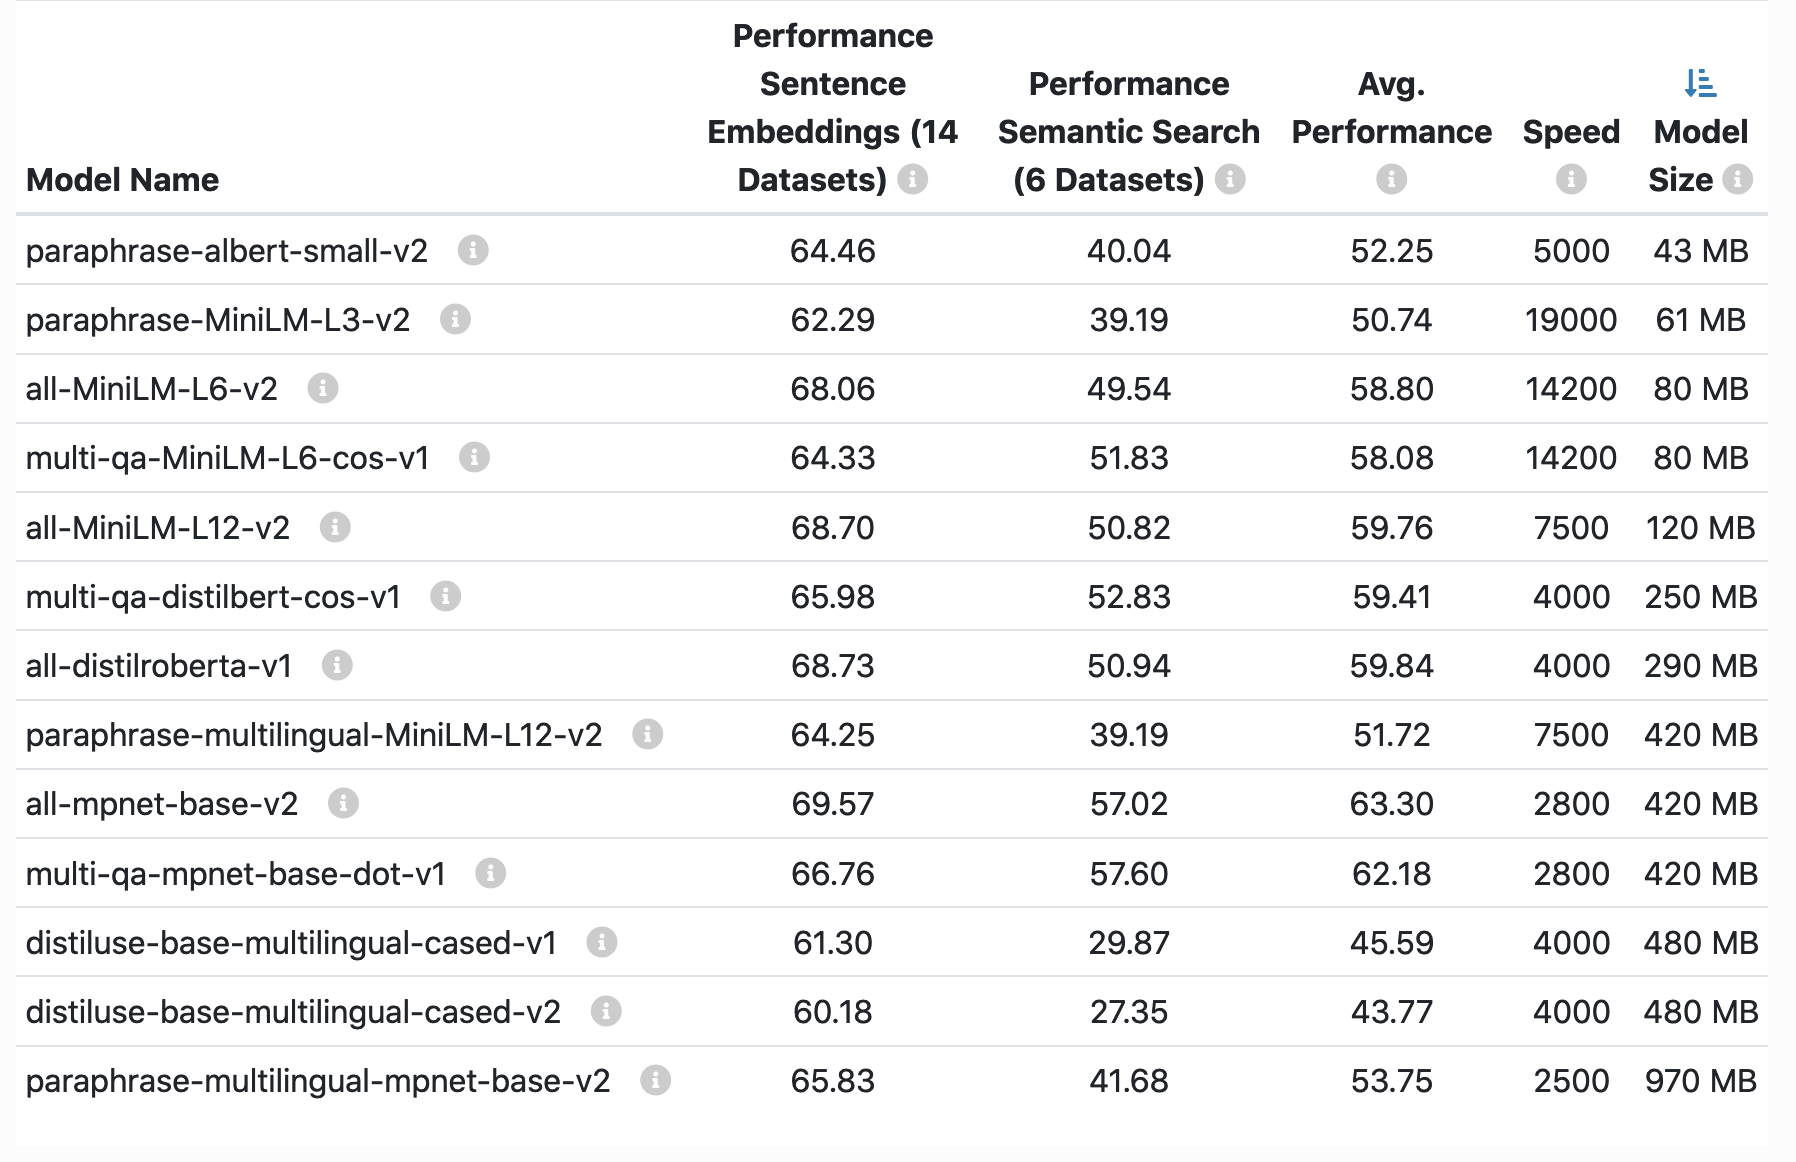



In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<b>Medical Question/Answer dataset</b>

This is a collection of data that contains medical questions and their corresponding answers. It contains information such as the question, the answer, and link to the question and answer set.

The dataset is gathered from online forums where patients and healthcare professionals ask and answer medical questions.

Specifically, we used a repository that contains medical Q/A datasets gathered from the following websites

*   eHealth Forum
*   iCliniq
*   Question Doctors
*   WebMD

Note that the data was gathered at the 5th of May 2017.

Link to dataset:
https://github.com/LasseRegin/medical-question-answer-data 

In [ ]:
link_to_dataset_on_drive = '/content/drive/MyDrive/Colab Notebooks/AI in Healthcare Project/health_dataset/'
datasets = [link_to_dataset_on_drive + 'ehealthforumQAs.json',
            link_to_dataset_on_drive + 'icliniqQAs.json',
            link_to_dataset_on_drive + 'questionDoctorQAs.json', 
            link_to_dataset_on_drive + 'webmdQAs.json']

#### Convert the json to a dataframe and check the size.

In [ ]:
df_health_ds = pd.DataFrame()

questions, answers, url = [], [], []

for dataset in datasets:
  data = json.load(open(dataset, 'r'))
  for i in data['pairs']:
    questions.append(i['question'])
    answers.append(i['answer'])
    url.append(i['url'])

df_health_ds['questions'] = questions
df_health_ds['answers'] = answers
df_health_ds['url'] = url

df_health_ds.shape

(29752, 3)

In [ ]:
df_health_ds.head()

,questions,answers,url
0,how do i stop smoking now,stopping smoking is about will power and being...,http://ehealthforum.com/health/stop-smoking-qu...
1,i had a tubaligation 4 years ago and also have...,hello this sounds quite unfamiliar that due to...,http://ehealthforum.com/health/endometriosis-q...
2,could extra caffeine consumption be a cause of...,extra caffeine can cause gastric discomfort th...,http://ehealthforum.com/health/caffeine-consum...
3,"hello- i am a 24 year old female 5""4 & 115 lb ...",hello thanks for submitting your question here...,http://ehealthforum.com/health/pcos-one-ovary-...
4,i was wanting to know if you could tell me if ...,i am glad to help you out. this is not possibl...,http://ehealthforum.com/health/not-knowing-you...


In [ ]:
for index, row in df_health_ds[:3].iterrows():
  print(row['questions'], '\n')
  print(row['answers'])
  print('===')

how do i stop smoking now 

stopping smoking is about will power and being steadfast. you can stop safely by having bupropion or nicotine patch cover initially in consult with a doctor. contact an addiction clinic near you. wishing you best of health thanks
===
i had a tubaligation 4 years ago and also have a minor case of endometriosis i am only 27 and my period stopped completely 3 months ago no more spotting in between nothing i am not stressed no change in daily habits diet weight nothing all urine pregnancy tests have been negative what could be wrong with me? 

hello this sounds quite unfamiliar that due to no reason at this age you have no cycle for last three months. pregnancy is surely a remote possibility as there was a tubal ligation. the endometriosis is also unlikely could cause stoppage of cycle. you definitely need some hormonal tests like thyroid or prolactin to know the balance inside as well as an withdrawal bleeding. meet your doctor for an evaluation.
===
could extr

#### First, we encode the questions and store the embeddings in order to avoid doing this every time because it takes a lot of time.

In [ ]:
### Compute embeddings for the questions. -- takes arount 17 minutes
%%time
df_health_ds['questions_embeddings'] = df_health_ds['questions'].apply(model.encode, convert_to_tensor=True)

CPU times: user 17min 43s, sys: 8 s, total: 17min 51s
Wall time: 17min 51s


We saved the dataframe as a pickle file instead of a CSV file because:

1. **Data Preservation:** Pickling preserves the datatype of columns and the dataframe structure. CSV file format only preserves the values but not the datatype, therefore loading the csv file would require specifying the datatype of columns again.

2. **Binary Format:** Pickle files are binary files, which means that they can be read and written quickly, and they take up less space on disk. CSV files, on the other hand, are text files, which can be larger and slower to read and write.

3. **Handling Non-string Data:** Pickle files can handle non-string data, such as numpy arrays, lists, and other complex data types, while CSV files can only handle string data.

In [ ]:
df_health_ds.to_pickle("df_health_ds.pkl")
file_path = "df_health_ds.pkl"

# Copy all the dataset to Drive
!cp -r "df_health_ds.pkl" '/content/drive/MyDrive/Colab Notebooks/AI in Healthcare Project/health_dataset/'

### End of Data Preprocessing
##### Continue in the next notebook